# Physical scene understanding lab

This lab introduces concepts and tools for inferring the properties of physical scenes. 



In [1]:
# Activate package
using Pkg;
Pkg.activate("/home/psyc261_meb266/Algorithms-of-the-Mind/jenv");

  Activating project at `~/Algorithms-of-the-Mind/jenv`


## Setup

Since this lab uses some extra dependencies, please make sure to follow these instructions carefully. 

### First time installations

> NOTE: You should only need to run this section once! After the dependencies are installed, you should not evaulate this section again.

We will need to install [pybullet](https://pybullet.org/wordpress/), the real time physics engine that we will be using under the hood.

In [2]:
using Conda
Conda.add("pybullet")

[ Info: Running `conda install -y pybullet` in root environment


Retrieving notices: ...working... done
Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.7.4

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.7.4




Let's check to make sure it installed properly.

In [3]:
using PyCall
pb = pyimport("pybullet")

[ Info: Precompiling PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
pybullet build time: May  2 2023 06:00:32


PyObject <module 'pybullet' from '/opt/julia/conda/3/x86_64/lib/python3.10/site-packages/pybullet.cpython-310-x86_64-linux-gnu.so'>

With this, we can install several julia packages. The first two provide functionality for inference over physical scenes. 

In [38]:
# Add PhySMC and PhyBullet
Pkg.add(url="https://github.com/CNCLgithub/PhySMC.git");
Pkg.add(url="https://github.com/CNCLgithub/PhyBullet.git");
Pkg.add("Accessors");
Pkg.add("Distributions");

   Resolving package versions...
    Updating `~/Algorithms-of-the-Mind/jenv/Project.toml`
  [31c24e10] + Distributions v0.25.100
  No Changes to `~/Algorithms-of-the-Mind/jenv/Manifest.toml`


### Loading dependencies

> NOTE: You should run this for each fresh boot (after installation)

In [11]:
using Gen;
using PhySMC;
using PhyBullet;
using PyCall; # helps with python commands
using Accessors; #helps with manipulating obj data

## Physical Generative Model

Define a generative model (`model`) that takes an initialized scene and then 

1) Samples new latents (mass and restitution)
2) Simulates `t` steps into the future
3) Generates noisy observations over object positions (in $\mathcal{R}^3$)

In [3]:
@gen function prior(ls::RigidBodyLatents)
    mass = @trace(gamma(1.2, 10.), :mass)
    res = @trace(uniform(0, 1), :restitution)

    new_ls = setproperties(ls.data;
                           mass = mass,
                           restitution = res)
    new_latents = RigidBodyLatents(new_ls)
    return new_latents
end

@gen function observe(k::RigidBodyState)
    pos = k.position # XYZ position
    # add noise to position
    obs = @trace(broadcasted_normal(pos, 0.01), :position)
    return obs
end

@gen function kernel(t::Int, prev_state::BulletState, sim::BulletSim)
    # use of PhySMC.step
    next_state::BulletState = PhySMC.step(sim, prev_state)
    # elem state could be a different type
    # but here we only have one `RigidBody` element
    # so  `next_state.kinematics = [RigidBodyState]`
    obs = @trace(Gen.Map(observe)(next_state.kinematics), :observe)
    return next_state
end

@gen function model(t::Int, sim::BulletSim, template::BulletState)
    # sample new mass and restitution for objects
    latents = @trace(Gen.Map(prior)(template.latents), :prior)
    init_state = setproperties(template; latents = latents)
    # simulate `t` timesteps
    states = @trace(Gen.Unfold(kernel)(t, init_state, sim), :kernel)
    return states
end;


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, BulletSim, BulletState], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##model#295", Bool[0, 0, 0], false)

## Defining a physical scene

Here, let's use `PhySMC` and `PhyBullet` to initialize a simple scene: a table with a ball directly above its center. 

In [8]:
function simple_scene(mass::Float64=1.0,
                      restitution::Float64=0.9)
    # `pb` is the `pybullet` python packaged and is exported by `PhyBullet`
    # initialize a physics server
    client = @pycall pb.connect(pb.DIRECT)::Int64
    pb.setGravity(0,0,-10; physicsClientId = client)

    # add a table
    dims = [1.0, 1.0, 0.1] # in meters
    col_id = pb.createCollisionShape(pb.GEOM_BOX,
                                     halfExtents = dims,
                                     physicsClientId = client)
    obj_id = pb.createMultiBody(baseCollisionShapeIndex = col_id,
                                basePosition = [0., 0., -0.1],
                                physicsClientId = client)
    pb.changeDynamics(obj_id,
                      -1;
                      mass = 0., # 0 mass are stationary
                      restitution = 0.9, # some is necessary
                      physicsClientId=client)


    # add a ball
    bcol_id = pb.createCollisionShape(pb.GEOM_SPHERE,
                                      radius = 0.1,
                                      physicsClientId = client)
    bobj_id = pb.createMultiBody(baseCollisionShapeIndex = bcol_id,
                                 basePosition = [0., 0., 1.0],
                                 physicsClientId = client)
    pb.changeDynamics(bobj_id,
                      -1;
                      mass = mass,
                      restitution = restitution,
                      physicsClientId=client)

    (client, bobj_id)
end

# start with a ball above a table
client, ball_id = simple_scene()
# configure simulator with the provided
# client id
sim = BulletSim(;client=client)
# This is the object of interest in the scene
# (the table is static)
ball = RigidBody(ball_id)
# Retrieve the default latents for the ball
# as well as its initial positions
# Note: alternative latents will be suggested by the `prior`
init_state = BulletState(sim, [ball])
# arguments for `model`
gargs = (60, # number of steps (total duration 1s)
         sim,
         init_state);

In [14]:
# execute `model`
trace, _ = generate(model, gargs);
get_choices(trace)
# visualize the height for the ball across time
# plt = draw_trace(trace)
    # visualize unique tracetories for different
    # resitution values
    # for i = 2:10
    #     trace, _ = generate(model, gargs)
    #     plt = update_plot(plt, trace, i)
    # end

│
├── :prior
│   │
│   └── 1
│       │
│       ├── :restitution : 0.11650446317359464
│       │
│       └── :mass : 24.513588755931355
│
└── :kernel
    │
    ├── 1
    │   │
    │   └── :observe
    │       │
    │       └── 1
    │           │
    │           └── :position : [-0.0016546982320231989, -0.00591520810251047, 0.9972820586172506]
    │
    ├── 2
    │   │
    │   └── :observe
    │       │
    │       └── 1
    │           │
    │           └── :position : [0.004931969228737467, -0.018704147086196745, 0.985824270952083]
    │
    ├── 3
    │   │
    │   └── :observe
    │       │
    │       └── 1
    │           │
    │           └── :position : [-0.010820031686232403, 0.006612772241394599, 0.9773165335527408]
    │
    ├── 4
    │   │
    │   └── :observe
    │       │
    │       └── 1
    │           │
    │           └── :position : [-0.002089446015678991, 0.010585691913032871, 0.9543542331773063]
    │
    ├── 5
    │   │
    │   └── :observe
    │       │
    │     

Let's also create a helper function to visualize the height of the ball as a function of time

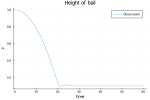

In [60]:
using Plots;

function get_zs(trace::Gen.Trace)
    t, _... = get_args(trace)
    states = get_retval(trace)
    zs = Vector{Float64}(undef, t)
    for i = 1:t
        zs[i] = states[i].kinematics[1].position[3]
    end
    return zs
end
function plot_zs(trace::Gen.Trace)
    zs = get_zs(trace)
    return plot(1:length(zs), zs, title="Height of ball", xlabel="time", ylabel="z", size=(1000,1000))
end

plot_zs(trace)

Here, we visualize how traces that sample a range of physical properties for the ball lead to different timecourses. 

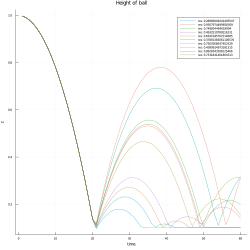

In [26]:
function plot_zs(traces::Vector{<:Gen.Trace})
    n = length(traces)
    t, _... = get_args(traces[1])
    plt = plot(title="Height of ball", xlabel="time", ylabel="z", size=(1000,1000))
    for i = 1:n
        restitution = traces[i][:prior => 1 => :restitution]
        plot!(plt, 1:t, get_zs(traces[i]), label = "res: $(restitution)")
    end
    return plt
end

traces = [first(generate(model, gargs)) for _ = 1:10]
plot_zs(traces)

In [ ]:
Note how restitution, and not mass, has any effect on the resulting trajectory. 

## Inference over dynamic scenes

Now that we have implemented a forward model over this simple scene, we can use to perform inferences given a set of observed positions




In [33]:
# First, let's generate a scene with a specific mass and restitution 
# (Note: this is "god-like" knowledge
gt_latents = choicemap(
    (:prior => 1 => :restitution, 0.8), 
    (:prior => 1 => :mass, 1.0))
gt = first(generate(model, gargs, gt_latents));
gt_choices = get_choices(gt)

t = gargs[1]

# one set of observations per time step
# (these do not contain gt latents)
observations = Vector{Gen.ChoiceMap}(undef, t)
for i = 1:t
    cm = choicemap()
    addr = :kernel => i => :observe
    set_submap!(cm, addr, get_submap(gt_choices, addr))
    observations[i] = cm
end

display(observations[1])

│
└── :kernel
    │
    └── 1
        │
        └── :observe
            │
            └── 1
                │
                └── :position : [0.0025100002635454932, -0.007585678943683167, 0.984438382430334]


Here, we define the inference procedure: a particle filter 

In [51]:
# First, we define a distribution that will be helpful in the proposal function
using Distributions
struct TruncNorm <: Gen.Distribution{Float64} end
const trunc_norm = TruncNorm()
function Gen.random(::TruncNorm, mu::U, noise::T, low::T, high::T) where {U<:Real,T<:Real}
    d = Distributions.Truncated(Distributions.Normal(mu, noise),
                                low, high)
    return Distributions.rand(d)
end;
function Gen.logpdf(::TruncNorm, x::Float64, mu::U, noise::T, low::T, high::T) where {U<:Real,T<:Real}
    d = Distributions.Truncated(Distributions.Normal(mu, noise),
                                low, high)
    return Distributions.logpdf(d, x)
end;


# this proposal function implements a truncated random walk for mass and restitution
@gen function proposal(tr::Gen.Trace)
    # HINT: https://www.gen.dev/tutorials/iterative-inference/tutorial#mcmc-2
    #
    # get previous values from `tr`
    choices = get_choices(tr)
    prev_mass = choices[:prior => 1 => :mass]
    prev_res  = choices[:prior => 1 => :restitution]
    
    # sample new values conditioned on the old ones
    # (Note: values are truncated to avoid issues with simulation)
    mass = {:prior => 1 => :mass} ~ trunc_norm(prev_mass, .1, 0., Inf)
    restitution = {:prior => 1 => :restitution} ~ trunc_norm(prev_res, .1, 0., 1.)
    
    # the return of this function is not
    # neccessary but could be useful
    # for debugging.
    return (mass, restitution)
end

"""
    inference_procedure

Performs particle filter inference with rejuvenation.
"""
function inference_procedure(gm_args::Tuple,
                             obs::Vector{Gen.ChoiceMap},
                             particles::Int = 50)
    get_args(t) = (t, gm_args[2:3]...)

    # initialize particle filter
    state = Gen.initialize_particle_filter(model, get_args(0), EmptyChoiceMap(), particles)
    argdiffs = (UnknownChange(), NoChange(), NoChange()) # only the first argument will change
    # Then increment through each observation step
    for (t, o) = enumerate(obs)
        # apply a rejuvenation move to each particle
        step_time = @elapsed begin
            for i=1:particles
                state.traces[i], _  = mh(state.traces[i], proposal, ())
            end
        
            Gen.maybe_resample!(state, ess_threshold=particles/2) 
            Gen.particle_filter_step!(state, get_args(t), argdiffs, o)
        end
    end

    return state.traces
    # return the "unweighted" set of traces after t steps
    # return Gen.sample_unweighted_traces(state, particles)
end;

We can now apply this inference procedure to infer the latents in our model that will best explain the set of observed positions. 

In [52]:
result = inference_procedure(gargs, observations); #should take a few seconds

By plotting the distribution of inferred latents, we see that indeed restitution converges to the ground truth, while mass varies arbitrarily.

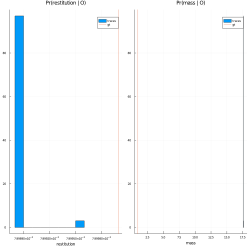

In [63]:
function get_latents(traces::Vector{<:Gen.Trace})
    n = length(traces)
    mass = Vector{Float64}(undef, n)
    restitution = Vector{Float64}(undef, n)
    for i = 1:n
        mass[i] = traces[i][:prior => 1 => :mass]
        restitution[i] = traces[i][:prior => 1 => :restitution]
    end
    (mass, restitution)
end

function plot_latents(traces::Vector{<:Gen.Trace})
    mass, restitution = get_latents(traces)
    res_plt = histogram(restitution, title="Pr(restitution | O)", 
        xlabel="restitution", bins = 10, label = "traces")
    vline!(res_plt, [0.8], label = "gt") 
    mass_plt = histogram(mass, title="Pr(mass | O)", xlabel="mass", bins=10,
        label = "traces")
    vline!(mass_plt, [1.0], label = "gt") 
    return plot(res_plt, mass_plt,size=(1000,1000))
end

plot_latents(result)

We can also examine how well the predicted trajectories line up with the observed one. 

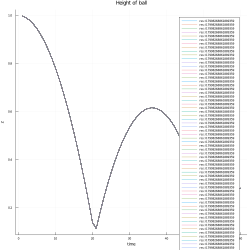

In [50]:
display(plot_zs(gt))
display(plot_zs(result))